In [1]:
!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="uN1O0EDdiSuJbSsnD4bb")
project = rf.workspace("tpva").project("albums2")
version = project.version(1)
dataset = version.download("folder")


loading Roboflow workspace...
loading Roboflow project...


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
from sklearn.metrics import classification_report, confusion_matrix, f1_score
import matplotlib.pyplot as plt
import numpy as np
import os
import seaborn as sns
from tqdm import tqdm

In [3]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
# Parameters
BATCH_SIZE = 50
IMG_SIZE = 224
NUM_WORKERS = 2

In [5]:
# Transforms
transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

---

In [6]:
import os
import shutil
from sklearn.model_selection import train_test_split
from collections import Counter
import random


In [8]:
# Path to your dataset
total_dataset_path = '/content/Albums2-1/train'

# Create a list of (file_path, label) pairs
data = []
for label in os.listdir(total_dataset_path):
    label_path = os.path.join(total_dataset_path, label)
    if os.path.isdir(label_path):
        for file_name in os.listdir(label_path):
            file_path = os.path.join(label_path, file_name)
            data.append((file_path, label))


In [9]:
# Extract file paths and labels
file_paths, labels = zip(*data)

# Perform stratified split
train_files, test_valid_files, train_labels, test_valid_labels = train_test_split(
    file_paths, labels, test_size=0.3, stratify=labels, random_state=42
)
test_files, valid_files, test_labels, valid_labels = train_test_split(
    test_valid_files, test_valid_labels, test_size=0.5, stratify=test_valid_labels, random_state=42
)

# Check distributions
print("Training distribution:", Counter(train_labels))
print("Validation distribution:", Counter(valid_labels))
print("Testing distribution:", Counter(test_labels))


Training distribution: Counter({'class5': 210, 'class9': 210, 'class2': 210, 'class12': 210, 'class11': 210, 'class1': 209, 'class14': 209, 'class4': 174, 'class7': 141, 'class6': 136, 'class15': 132, 'class13': 121, 'class8': 111, 'class3': 106})
Validation distribution: Counter({'class14': 45, 'class2': 45, 'class1': 45, 'class5': 45, 'class11': 45, 'class9': 45, 'class12': 45, 'class4': 38, 'class7': 31, 'class6': 29, 'class15': 29, 'class13': 26, 'class8': 23, 'class3': 22})
Testing distribution: Counter({'class2': 45, 'class5': 45, 'class1': 45, 'class11': 45, 'class9': 45, 'class12': 45, 'class14': 45, 'class4': 37, 'class7': 30, 'class6': 29, 'class15': 28, 'class13': 26, 'class8': 24, 'class3': 23})


In [10]:
# Create directories
output_dir = '/content/split_dataset'
for split in ['train', 'valid', 'test']:
    split_path = os.path.join(output_dir, split)
    os.makedirs(split_path, exist_ok=True)
    for label in os.listdir(total_dataset_path):
        os.makedirs(os.path.join(split_path, label), exist_ok=True)

# Helper function to move files
def move_files(file_list, split):
    for file_path, label in file_list:
        dest_path = os.path.join(output_dir, split, label, os.path.basename(file_path))
        shutil.copy(file_path, dest_path)

# Move files
move_files(zip(train_files, train_labels), 'train')
move_files(zip(valid_files, valid_labels), 'valid')
move_files(zip(test_files, test_labels), 'test')


In [11]:
# Create directories
output_dir = '/content/split_dataset'
for split in ['train', 'valid', 'test']:
    split_path = os.path.join(output_dir, split)
    os.makedirs(split_path, exist_ok=True)
    for label in os.listdir(total_dataset_path):
        os.makedirs(os.path.join(split_path, label), exist_ok=True)

# Helper function to move files
def move_files(file_list, split):
    for file_path, label in file_list:
        dest_path = os.path.join(output_dir, split, label, os.path.basename(file_path))
        shutil.copy(file_path, dest_path)

# Move files
move_files(zip(train_files, train_labels), 'train')
move_files(zip(valid_files, valid_labels), 'valid')
move_files(zip(test_files, test_labels), 'test')


In [12]:
# Balance training data
train_output_path = os.path.join(output_dir, 'train')
train_data = []

for label in os.listdir(train_output_path):
    label_path = os.path.join(train_output_path, label)
    files = os.listdir(label_path)
    train_data.append((label, files))

# Calculate the maximum samples per class
max_samples = max(len(files) for _, files in train_data)

# Duplicate underrepresented classes
for label, files in train_data:
    label_path = os.path.join(train_output_path, label)
    while len(files) < max_samples:
        file_to_duplicate = random.choice(files)
        src = os.path.join(label_path, file_to_duplicate)
        base_name = os.path.basename(file_to_duplicate)
        dest = os.path.join(label_path, f"dup_{len(files)}_{base_name}")
        shutil.copy(src, dest)
        files.append(f"dup_{len(files)}_{base_name}")

print("Balanced training set created!")


Balanced training set created!


---

In [13]:
train_dir = '/content/split_dataset/train'
validation_dir = '/content/split_dataset/valid'
test_dir = '/content/split_dataset/test'

In [14]:
# Datasets
train_dataset = datasets.ImageFolder(train_dir, transform=transform)
val_dataset = datasets.ImageFolder(validation_dir, transform=transform)
test_dataset = datasets.ImageFolder(test_dir, transform=transform)

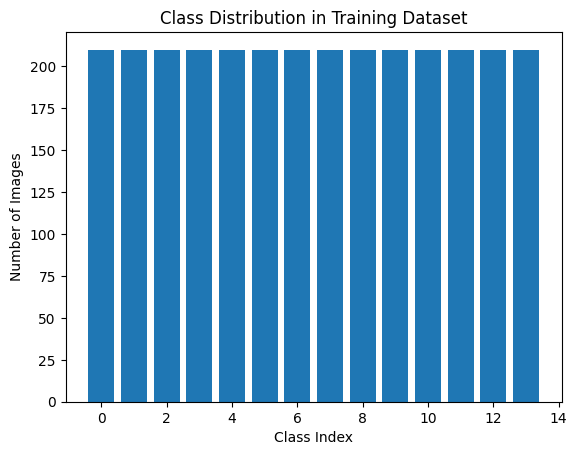

Class 0: 210 images
Class 1: 210 images
Class 2: 210 images
Class 3: 210 images
Class 4: 210 images
Class 5: 210 images
Class 6: 210 images
Class 7: 210 images
Class 8: 210 images
Class 9: 210 images
Class 10: 210 images
Class 11: 210 images
Class 12: 210 images
Class 13: 210 images


In [15]:
from collections import Counter
import matplotlib.pyplot as plt

# Count occurrences of each class in the training dataset
class_counts = Counter([label for _, label in train_dataset])

# Visualize class distribution
plt.bar(class_counts.keys(), class_counts.values())
plt.xlabel("Class Index")
plt.ylabel("Number of Images")
plt.title("Class Distribution in Training Dataset")
plt.show()

# Print the class counts for reference
for class_idx, count in sorted(class_counts.items()):
    print(f"Class {class_idx}: {count} images")


In [16]:
 #DataLoaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)

In [17]:
# Class names and number of classes
class_names = train_dataset.classes
num_classes = len(class_names)
print(f"Number of classes: {num_classes}")

Number of classes: 14


In [19]:
# Define the model
class EfficientNetClassifier(nn.Module):
    def __init__(self, num_classes):
        super(EfficientNetClassifier, self).__init__()
        self.base_model = models.efficientnet_b0(weights="IMAGENET1K_V1")
        self.base_model.classifier[1] = nn.Linear(self.base_model.classifier[1].in_features, num_classes)

    def forward(self, x):
        return self.base_model(x)

In [20]:
model = EfficientNetClassifier(num_classes).to(device)

Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 40.8MB/s]


In [21]:
# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [22]:
# Learning rate scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', patience=3, factor=0.5)

In [23]:
class EarlyStopping:
    def __init__(self, patience=5, delta=0.0):
        self.patience = patience
        self.delta = delta
        self.best_score = None
        self.counter = 0
        self.early_stop = False

    def __call__(self, metric):
        if self.best_score is None or metric > self.best_score + self.delta:
            self.best_score = metric
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True

In [24]:
# Training loop with model saving
def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs=1, save_interval=1, patience=3):
    history = {"train_loss": [], "val_loss": [], "train_acc": [], "val_acc": []}

    # Early stopping variables
    best_val_acc = 0.0
    early_stop_counter = 0

    for epoch in tqdm(range(num_epochs)):
        # Training
        model.train()
        running_loss, correct = 0.0, 0
        for inputs, labels in tqdm(train_loader, leave=False):
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            correct += (outputs.argmax(1) == labels).sum().item()

        train_loss = running_loss / len(train_loader.dataset)
        train_acc = correct / len(train_loader.dataset)
        history["train_loss"].append(train_loss)
        history["train_acc"].append(train_acc)

        # Validation
        model.eval()
        running_loss, correct = 0.0, 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                running_loss += loss.item() * inputs.size(0)
                correct += (outputs.argmax(1) == labels).sum().item()

        val_loss = running_loss / len(val_loader.dataset)
        val_acc = correct / len(val_loader.dataset)
        history["val_loss"].append(val_loss)
        history["val_acc"].append(val_acc)

        # Adjust learning rate
        scheduler.step(val_acc)

        print(f"Epoch {epoch+1}/{num_epochs}: "
              f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, "
              f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

        # Save model every save_interval epochs
        if (epoch + 1) % save_interval == 0:
            model_filename = f"modelTorch_{epoch+1}epochs_Rebalanced.pth"
            torch.save({
                'epoch': epoch + 1,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict()
            }, model_filename)
            print(f"Model saved as {model_filename}")

        # Early stopping logic
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            early_stop_counter = 0  # Reset counter if improvement
        else:
            early_stop_counter += 1
            print(f"No improvement for {early_stop_counter} epoch(s).")

        if early_stop_counter >= patience:
            print(f"Early stopping triggered after {epoch+1} epochs.")
            break

    return history

In [25]:
history = train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs=10, save_interval=1, patience=3)

 10%|█         | 1/10 [12:54<1:56:09, 774.34s/it]

Epoch 1/10: Train Loss: 2.4077, Train Acc: 0.2276, Val Loss: 2.5710, Val Acc: 0.1365
Model saved as modelTorch_1epochs_Rebalanced.pth



 20%|██        | 2/10 [25:43<1:42:51, 771.45s/it]

Epoch 2/10: Train Loss: 1.7046, Train Acc: 0.4639, Val Loss: 2.7108, Val Acc: 0.1540
Model saved as modelTorch_2epochs_Rebalanced.pth



 30%|███       | 3/10 [38:35<1:30:00, 771.48s/it]

Epoch 3/10: Train Loss: 1.1503, Train Acc: 0.6418, Val Loss: 3.0913, Val Acc: 0.1657
Model saved as modelTorch_3epochs_Rebalanced.pth



 40%|████      | 4/10 [51:23<1:17:00, 770.05s/it]

Epoch 4/10: Train Loss: 0.7573, Train Acc: 0.7582, Val Loss: 3.4717, Val Acc: 0.1618
Model saved as modelTorch_4epochs_Rebalanced.pth
No improvement for 1 epoch(s).



 50%|█████     | 5/10 [1:04:09<1:04:03, 768.78s/it]

Epoch 5/10: Train Loss: 0.4903, Train Acc: 0.8446, Val Loss: 3.7635, Val Acc: 0.1618
Model saved as modelTorch_5epochs_Rebalanced.pth
No improvement for 2 epoch(s).



 60%|██████    | 6/10 [1:16:51<51:05, 766.40s/it]  

Epoch 6/10: Train Loss: 0.3512, Train Acc: 0.8932, Val Loss: 4.1591, Val Acc: 0.1793
Model saved as modelTorch_6epochs_Rebalanced.pth



 70%|███████   | 7/10 [1:29:33<38:14, 764.95s/it]

Epoch 7/10: Train Loss: 0.2582, Train Acc: 0.9184, Val Loss: 4.3502, Val Acc: 0.1657
Model saved as modelTorch_7epochs_Rebalanced.pth
No improvement for 1 epoch(s).



 80%|████████  | 8/10 [1:42:15<25:28, 764.01s/it]

Epoch 8/10: Train Loss: 0.1959, Train Acc: 0.9412, Val Loss: 5.0521, Val Acc: 0.1637
Model saved as modelTorch_8epochs_Rebalanced.pth
No improvement for 2 epoch(s).



 80%|████████  | 8/10 [1:54:46<28:41, 860.85s/it]

Epoch 9/10: Train Loss: 0.2151, Train Acc: 0.9344, Val Loss: 4.5639, Val Acc: 0.1676
Model saved as modelTorch_9epochs_Rebalanced.pth
No improvement for 3 epoch(s).
Early stopping triggered after 9 epochs.


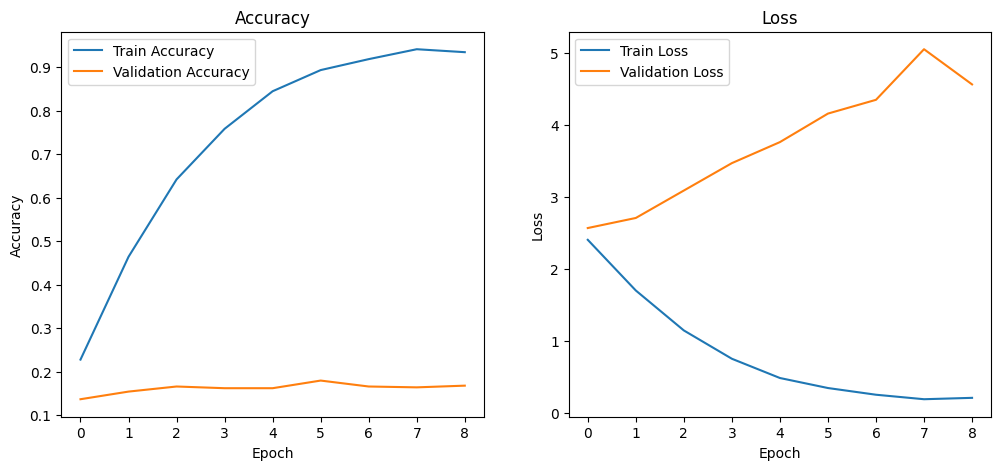

In [26]:
# Plot accuracy and loss
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history["train_acc"], label="Train Accuracy")
plt.plot(history["val_acc"], label="Validation Accuracy")
plt.title("Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history["train_loss"], label="Train Loss")
plt.plot(history["val_loss"], label="Validation Loss")
plt.title("Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.show()

F1 Score: 0.9901
              precision    recall  f1-score   support

      class1       1.00      0.98      0.99       210
     class11       1.00      0.98      0.99       210
     class12       0.97      1.00      0.99       210
     class13       1.00      1.00      1.00       210
     class14       1.00      1.00      1.00       210
     class15       1.00      1.00      1.00       210
      class2       0.97      0.99      0.98       210
      class3       0.99      1.00      1.00       210
      class4       0.99      0.99      0.99       210
      class5       1.00      0.97      0.98       210
      class6       1.00      0.97      0.99       210
      class7       0.99      1.00      0.99       210
      class8       1.00      1.00      1.00       210
      class9       0.99      1.00      1.00       210

    accuracy                           0.99      2940
   macro avg       0.99      0.99      0.99      2940
weighted avg       0.99      0.99      0.99      2940



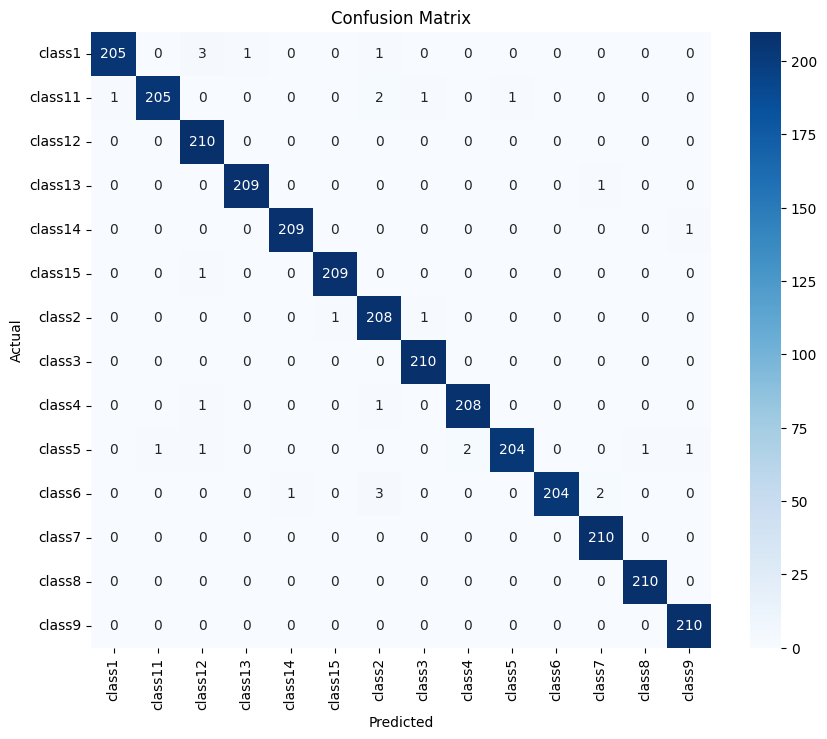

In [27]:
#ACC Y CONF MAT DE TRAIN
model.eval()
all_preds, all_labels = [], []
with torch.no_grad():
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        all_preds.append(outputs.argmax(1).cpu().numpy())
        all_labels.append(labels.cpu().numpy())

all_preds = np.concatenate(all_preds)
all_labels = np.concatenate(all_labels)


f1 = f1_score(all_labels, all_preds, average='weighted')
print(f"F1 Score: {f1:.4f}")
print(classification_report(all_labels, all_preds, target_names=class_names))


conf_mat = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(10, 8))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

F1 Score: 0.1647
              precision    recall  f1-score   support

      class1       0.19      0.16      0.17        45
     class11       0.29      0.24      0.27        45
     class12       0.14      0.22      0.17        45
     class13       0.12      0.12      0.12        26
     class14       0.15      0.18      0.16        45
     class15       0.12      0.14      0.13        29
      class2       0.06      0.07      0.07        45
      class3       0.23      0.23      0.23        22
      class4       0.28      0.24      0.26        38
      class5       0.15      0.13      0.14        45
      class6       0.09      0.03      0.05        29
      class7       0.13      0.06      0.09        31
      class8       0.24      0.30      0.27        23
      class9       0.17      0.22      0.19        45

    accuracy                           0.17       513
   macro avg       0.17      0.17      0.16       513
weighted avg       0.17      0.17      0.16       513



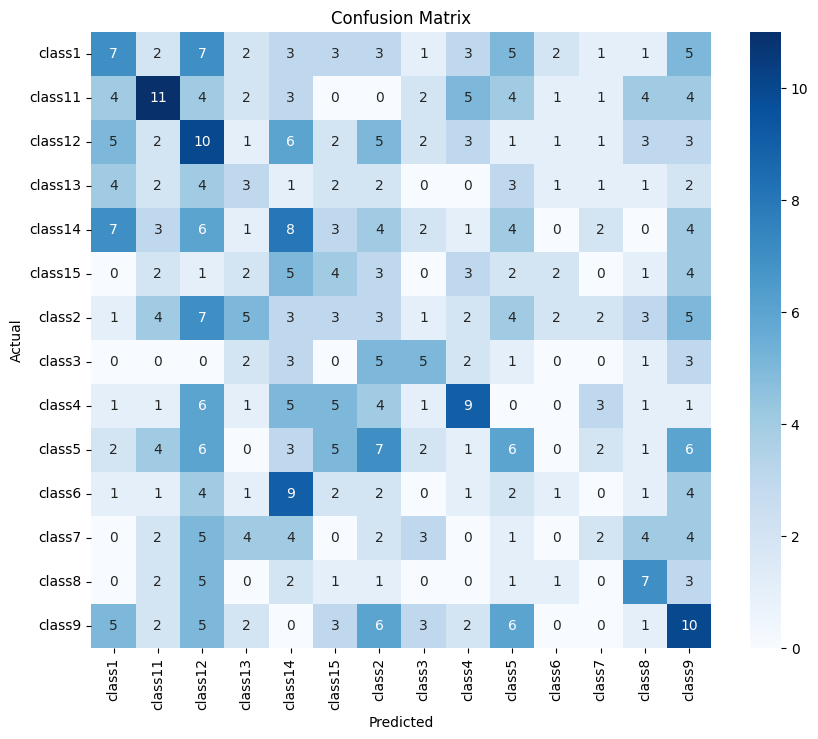

In [28]:
#ACC Y CONF MAT DE VAL
model.eval()
all_preds, all_labels = [], []
with torch.no_grad():
    for inputs, labels in val_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        all_preds.append(outputs.argmax(1).cpu().numpy())
        all_labels.append(labels.cpu().numpy())

all_preds = np.concatenate(all_preds)
all_labels = np.concatenate(all_labels)


f1 = f1_score(all_labels, all_preds, average='weighted')
print(f"F1 Score: {f1:.4f}")
print(classification_report(all_labels, all_preds, target_names=class_names))


conf_mat = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(10, 8))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

F1 Score: 0.1321
              precision    recall  f1-score   support

      class1       0.12      0.11      0.12        45
     class11       0.20      0.18      0.19        45
     class12       0.11      0.20      0.14        45
     class13       0.04      0.04      0.04        26
     class14       0.15      0.18      0.16        45
     class15       0.15      0.18      0.16        28
      class2       0.11      0.09      0.10        45
      class3       0.10      0.09      0.09        23
      class4       0.42      0.35      0.38        37
      class5       0.11      0.07      0.08        45
      class6       0.00      0.00      0.00        29
      class7       0.19      0.10      0.13        30
      class8       0.00      0.00      0.00        24
      class9       0.12      0.18      0.14        45

    accuracy                           0.13       512
   macro avg       0.13      0.13      0.12       512
weighted avg       0.14      0.13      0.13       512



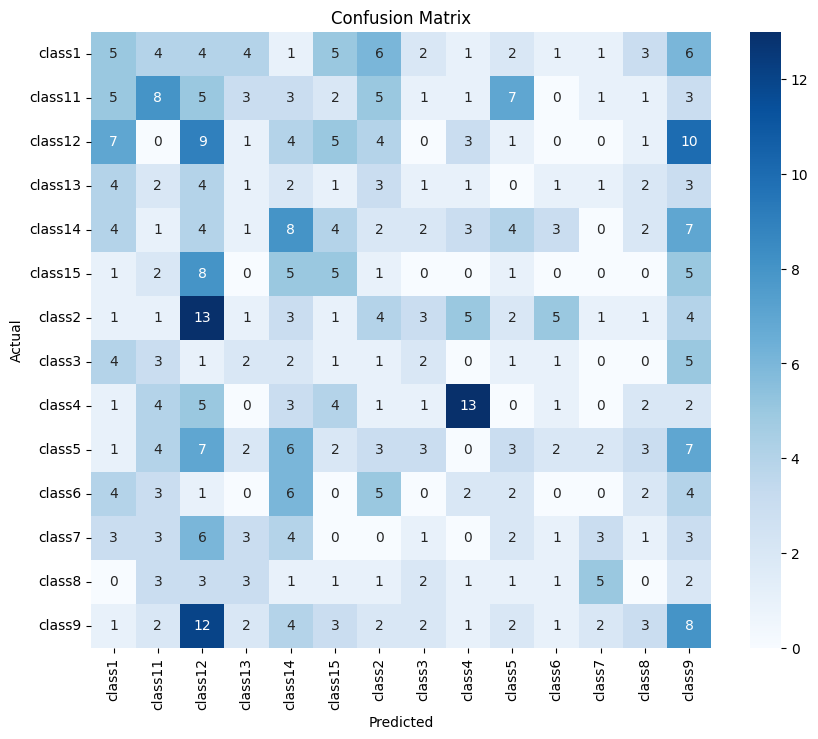

In [29]:
#ACC Y CONF MAT DE TEST
model.eval()
all_preds, all_labels = [], []
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        all_preds.append(outputs.argmax(1).cpu().numpy())
        all_labels.append(labels.cpu().numpy())

all_preds = np.concatenate(all_preds)
all_labels = np.concatenate(all_labels)


f1 = f1_score(all_labels, all_preds, average='weighted')
print(f"F1 Score: {f1:.4f}")
print(classification_report(all_labels, all_preds, target_names=class_names))


conf_mat = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(10, 8))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()